### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

![alt text](images/2.png)

In [1]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model="qwen-2.5-32b")

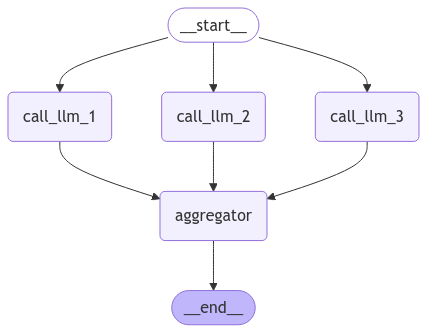

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

class State(TypedDict):
    topic: str
    title: str
    contestant1: str
    contestant2: str
    combined:str

def llmcall1(state:State):
    msg=llm.invoke(f"create a title for a debate on the topic:{state['topic']}")
    return {'title':msg.content}

def llmcall2(state:State):
    msg=llm.invoke(f"create 300 words to speak for the topic:{state['topic']}")
    return {'contestant1':msg.content}

def llmcall3(state:State):
    msg=llm.invoke(f"create 300 words to speak against the topic:{state['topic']}")
    return {'contestant2':msg.content}

def aggregator(state:State):
    msg=f"Title for the debate is:\n{state['title']}\n\n"
    msg+=f"Contestant1: \n {state['contestant1']}\n\n"
    msg+=f"Contestant2: \n {state['contestant2']}\n\n"
    return {'combined':msg}

parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1", llmcall1)
parallel_builder.add_node("call_llm_2", llmcall2)
parallel_builder.add_node("call_llm_3", llmcall3)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [12]:
response=parallel_workflow.invoke({'topic':"Democracy made India Stronger"})

In [13]:
response['title']

'"Strength in Numbers: Debating the Impact of Democracy on India\'s Rise"'

In [18]:
print(response['combined'])

Title for the debate is:
"Strength in Numbers: Debating the Impact of Democracy on India's Rise"

Contestant1: 
 Democracy has been a cornerstone of India's national identity since its independence in 1947. The democratic framework, underpinned by the Constitution, has made India stronger in numerous ways, fostering a robust society and a resilient economy.

Firstly, democracy has enabled a pluralistic society where diverse voices are heard and represented. India's vast tapestry of cultures, languages, and religions finds expression through democratic institutions, ensuring that no single group dominates. This inclusivity has been a source of strength, allowing for the peaceful coexistence of various communities. It has also facilitated a dynamic civil society, where citizens can organize, advocate, and influence policies that affect their lives.

Economically, democracy has spurred development by encouraging entrepreneurship and innovation. The presence of a free press and relatively 